In [9]:
import keras
import os
#os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]


import keras
import numpy as np
from keras_cv import bounding_box
import keras_cv
from keras_cv import visualization
import tqdm
import numpy as np

In [3]:
distilled_model_path = "TensorFlow/workspace/training_demo/distil_models/"
teacher_model = keras.models.load_model(distilled_model_path + 'MobileNet_distilled')


2024-05-29 13:00:51.992812: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 13:00:52.008241: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 13:00:52.008399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 13:00:52.012576: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 13:00:52.012790: I external/local_xla/xla/stream_executor

In [4]:
teacher_model.summary()


Model: "mobilenet_1.00_640"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 640, 640, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 320, 320, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 320, 320, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 320, 320, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 320, 320, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 320, 320, 32

In [13]:
filepath = "TensorFlow/workspace/training_demo/images/test/Cars411.png"
image = keras.utils.load_img(filepath)
image = np.array(image)

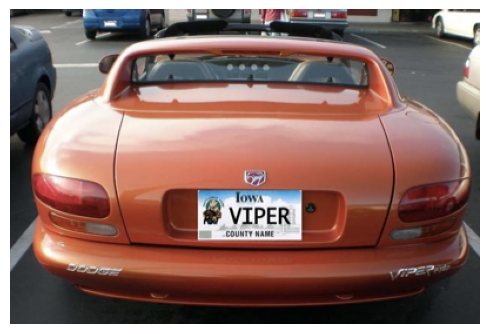

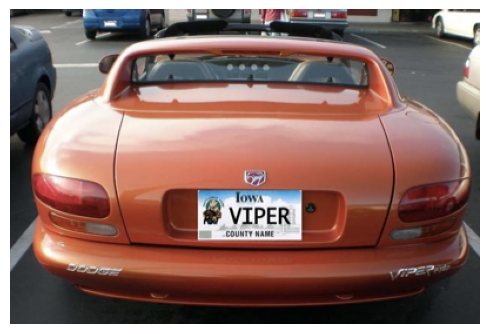

In [14]:
visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)

In [6]:
class_ids = [
    "Licence",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [11]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)
image_batch = inference_resizing([image])

1/1 [==============================] - 0s 38ms/step
Detection Output: [[1.05477497e-02 5.48361689e-02 2.18336321e-02 7.39233568e-03
  7.29195680e-03 1.49306993e-03 7.44304247e-03 1.39714114e-03
  9.96692199e-03 2.12862398e-02 6.65788772e-04 6.53008791e-03
  8.45056120e-03 8.23254993e-08 8.91552831e-04 6.54826872e-04
  7.27171004e-02 5.09979727e-04 6.23012253e-04 9.06612817e-03
  8.36843811e-03 2.59027723e-02 4.34997585e-03 4.66753952e-02
  5.27118209e-05 2.85557122e-03 1.86907523e-03 2.75382219e-04
  6.07483415e-03 8.57525971e-03 3.10575310e-03 7.89218768e-03
  6.21375218e-02 3.95296980e-03 1.03943674e-02 1.30629474e-02
  4.24920907e-03 1.70372929e-02 4.79621254e-03 1.83498878e-02
  2.10793801e-02 1.53919123e-02 6.05024747e-04 1.32796390e-03
  5.70592703e-04 1.55429607e-02 7.64190452e-03 2.36308519e-02
  1.28710677e-03 1.32945981e-02 3.37785413e-03 2.61491572e-04
  5.33490907e-03 1.64945307e-03 5.82415087e-04 5.48815494e-03
  6.98526716e-03 1.17518706e-04 1.48747107e-02 2.49835402e-02


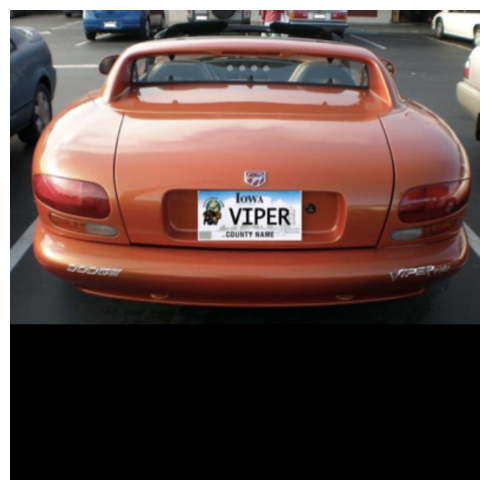

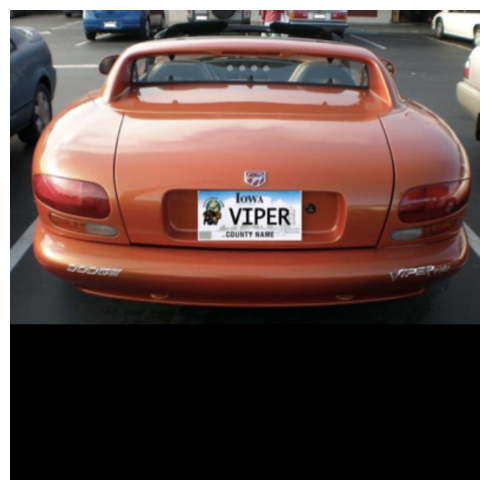

In [20]:
detection = teacher_model.predict(image_batch)
print("Detection Output:", detection)

# Przetwarzanie wyników predykcji
threshold = 0.5
boxes = []
classes = []
for i, score in enumerate(detection[0]):
    if score > threshold:
        # Debugowanie: Wyświetlanie wartości progowych
        print(f"Class {i}, Score: {score}")

        # Dodaj ramkę. Tu zakładamy, że ramki są znormalizowane do [0, 1]
        # Przykładowe współrzędne ramki; dostosuj według potrzeb
        x_center = (i % 10) * 0.1
        y_center = (i // 10) * 0.1
        width = 0.1
        height = 0.1
        boxes.append([x_center, y_center, width, height])
        classes.append(0)  # Zakładamy, że wszystkie wykryte obiekty należą do klasy "Licence"

# Sprawdź, czy lista boxes nie jest pusta
if len(boxes) == 0:
    boxes.append([0, 0, 0, 0])  # Przykładowa ramka w razie braku wykrycia
    classes.append(-1)  # Przykładowa klasa w razie braku wykrycia

# Konwersja do tablic numpy
boxes = np.array(boxes)
classes = np.array(classes)

# Dodanie wymiaru partii do ramek
boxes = np.expand_dims(boxes, axis=0)
classes = np.expand_dims(classes, axis=0)

# Debugowanie: Wyświetlanie współrzędnych ramek
print("Boxes:", boxes)
print("Classes:", classes)

# Przygotowanie wyników do wizualizacji
detection_dict = {
    "boxes": boxes,
    "classes": classes
}

# Wizualizacja ramek
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=detection_dict,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)
